# Information

In this notebook we will simulate different types of queues to calculate the average waiting times.

Note that some simulations might take a while, so it is adviced to adjust some of the parameters in this notebook, so it can be executed in its entirety a bit quicker.

In [125]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Generator, List, Callable, Union, Tuple
from scipy.stats import norm

### Functions for simulating a (Markovian) queue network

In [126]:
def interval_generator_markov(arrival_rate: float) -> float:
    """Generate a random number from the distribution of Markovian interarrival times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'arrival rate' = λ.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).

    Returns:
        Random number sampled from an exponential distribution with parameter arrival rate.
    """
    return random.expovariate(arrival_rate)


def service_time_generator_markov(service_rate: float) -> float:
    """Generate a random number from the distribution of Markovian service times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'service rate' = μ.

    Args:
        service_rate: The service rate or capacity of each server (μ).

    Returns:
        Random number sampled from an exponential distribution with parameter service rate.
    """
    return random.expovariate(service_rate)


def markovian_client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system, including waiting and service times.

    Specifically, samples service time from an exponential (markovian) distribution.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        # Wait for resource availability
        yield request

        # Record the wait time
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)

        # Simulate service time
        yield env.timeout(service_time_generator_markov(service_rate))


def request_spawner(
    env: simpy.Environment,
    resources: Union[simpy.Resource, simpy.PriorityResource],
    arrival_rate: float,
    service_rate: float,
    wait_records: List[float],
    client_process: Callable,
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes based on the interarrival time distribution.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by clients.
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.
        client_process: Function that calculates the process of a client through the system.

    Yields:
        Events representing client arrivals and process creation.
    """
    while True:
        yield env.timeout(interval_generator_markov(arrival_rate))
        env.process(
            client_process(env, resources, service_rate, wait_records)
        )
    
    
def simulate_queue_network(
    num_servers: int,
    arrival_rate: float,
    service_rate: float,
    sim_time: float,
    client_process: Callable = markovian_client_process,
    short_job_priority: bool = False,
) -> List[float]:
    """Simulates a queueing network with Markovian arrival and service processes.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        sim_time: Total simulation time.
        client_process: Function that calculates the process of a client through the system.
            Defaults to process with markovian service time.
        short_job_priority: Scheduling type for queue network. SJP if True, FIFO else.

    Returns:
        A list of recorded wait times for all clients during the simulation.
    """
    # Calculate load factor (ρ) as λ / (n * μ)
    load_factor = arrival_rate / (num_servers * service_rate)
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    # Set up simulation based on the job scheduling type
    env = simpy.Environment()
    if short_job_priority:
        resources = simpy.PriorityResource(env, capacity=num_servers)
    else:
        resources = simpy.Resource(env, capacity=num_servers)

    # Spawn clients and record their waiting time
    wait_records: List[float] = []
    env.process(
        request_spawner(
            env, resources, arrival_rate, service_rate, wait_records, client_process
        )
    )

    # Run the simulation
    env.run(until=sim_time)

    return wait_records

### Helper functions for comparing queue networks with different load factors

In [127]:
def run_simulations(
    load_factors: List[float],
    runs_per_config: int,
    servers_count: int,
    service_rate: float,
    simulation_time: int,
    client_process: Callable = markovian_client_process,
) -> pd.DataFrame:
    """Run multiple simulations for a queueing network under various configurations.

    Specifically, runs M/M/n FIFO by default.

    Args:
        load_factors: A list of load factors (ρ) to simulate.
        runs_per_config: The number of iterations to run for each load factor.
        servers_count: The number of servers in the queueing network.
        service_rate: The rate at which each server processes requests.
        simulation_time: The total time for each simulation run.
        client_process: Function that calculates the process of a client through the system.
            Defaults to process with markovian service time.

    Returns:
        A pandas DataFrame containing the simulation results with columns:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Servers": The number of servers in the system.
            - "Customers": The number of customers considered.
            - "Iteration": The simulation iteration number.
            - "Mean Wait Time": The average waiting time for the given number of customers.
    """
    # Using a dictionary for results storage
    results_dict = {
        "Load Factor": [],
        "Servers": [],
        "Customers": [],
        "Iteration": [],
        "Mean Wait Time": [],
    }

    # Simulations with progress bars
    for load_factor in tqdm(load_factors, desc="Running simulations for different load factors"):
        arrival_rate = load_factor * servers_count * service_rate
        for iteration in tqdm(
            range(runs_per_config), leave=False, desc=f"Simulating for ρ={load_factor:.2f}"
        ):
            recorded_waits = simulate_queue_network(
                servers_count, arrival_rate, service_rate, simulation_time, client_process=client_process
            )
            customer_counts = np.arange(10, 30000, 1000)
            for count in customer_counts:
                average_wait = np.mean(recorded_waits[:count])
                results_dict["Load Factor"].append(load_factor)
                results_dict["Servers"].append(servers_count)
                results_dict["Customers"].append(count)
                results_dict["Iteration"].append(iteration)
                results_dict["Mean Wait Time"].append(average_wait)

    # Convert the dictionary to a DataFrame
    results_df = pd.DataFrame(results_dict)
    return results_df


def plot_simulations(
    results_df: pd.DataFrame,
    load_factors: List[float],
    plot_title: str = "Average Waiting Time vs Number of Customers",
) -> None:
    """Plot the average waiting time as a function of the number of customers.

    Args:
        results_df: A pandas DataFrame containing simulation results, including:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Customers": The number of customers considered.
            - "Mean Wait Time": The average waiting time for the given number of customers.
        load_factors: A list of load factors (ρ) to include in the plot.
        plot_title: Title of the plot.

    Returns:
        None. Displays a plot showing the relationship between the number of customers
        and the average waiting time for each load factor.
    """
    # Plotting the results
    plt.figure(figsize=(8, 6))
    for load_factor in load_factors:
        subset = results_df[results_df["Load Factor"] == load_factor]
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
        plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load_factor}")

    plt.title(plot_title, fontsize=16)
    plt.xlabel("Number of Customers", fontsize=16)
    plt.ylabel("Average Waiting Time (s)", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=12)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

### M/M/1

Running simulations for different load factors: 100%|██████████| 4/4 [00:56<00:00, 14.07s/it]


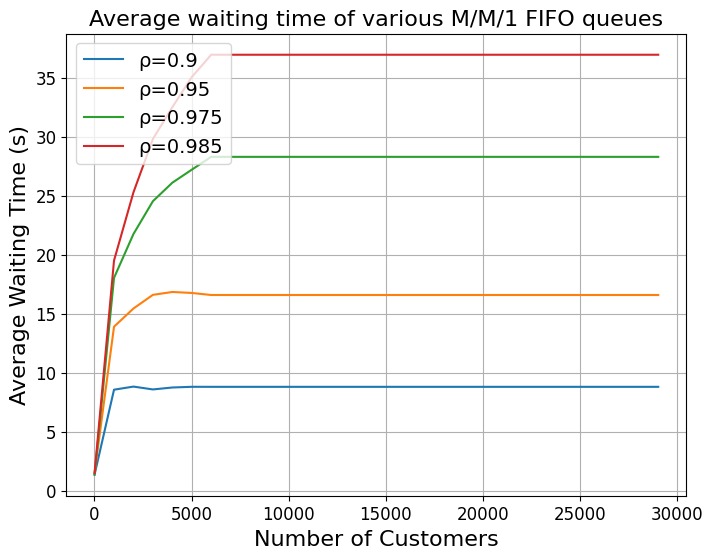

In [128]:
# Parameters
load_factors = [0.90, 0.95, 0.975, 0.985]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 100

# Run simulations
results_df_mm1 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm1.to_csv("sim_mm1.csv", index=False)

# Plot the results
plot_simulations(results_df_mm1, load_factors, plot_title="Average waiting time of various M/M/1 FIFO queues")

### M/M/2

Running simulations for different load factors: 100%|██████████| 4/4 [01:41<00:00, 25.50s/it]


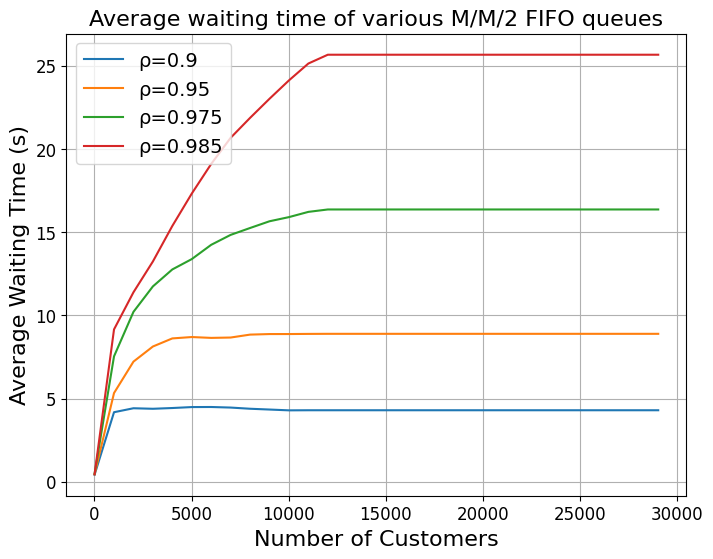

In [129]:
# Adjust server count to 2
servers_count = 2

# Run simulations
results_df_mm2 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm2.to_csv("sim_mm2.csv", index=False)

# Plot the results
plot_simulations(results_df_mm2, load_factors, plot_title="Average waiting time of various M/M/2 FIFO queues")

### M/M/4

Running simulations for different load factors: 100%|██████████| 4/4 [03:11<00:00, 47.92s/it]


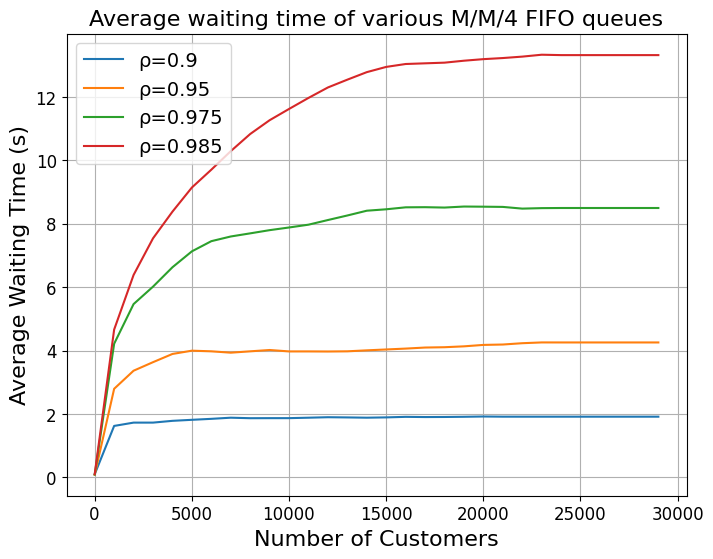

In [130]:
# Adjust server count to 4
servers_count = 4

# Run simulations
results_df_mm4 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm4.to_csv("sim_mm4.csv", index=False)

# Plot the results
plot_simulations(results_df_mm4, load_factors, plot_title="Average waiting time of various M/M/4 FIFO queues")

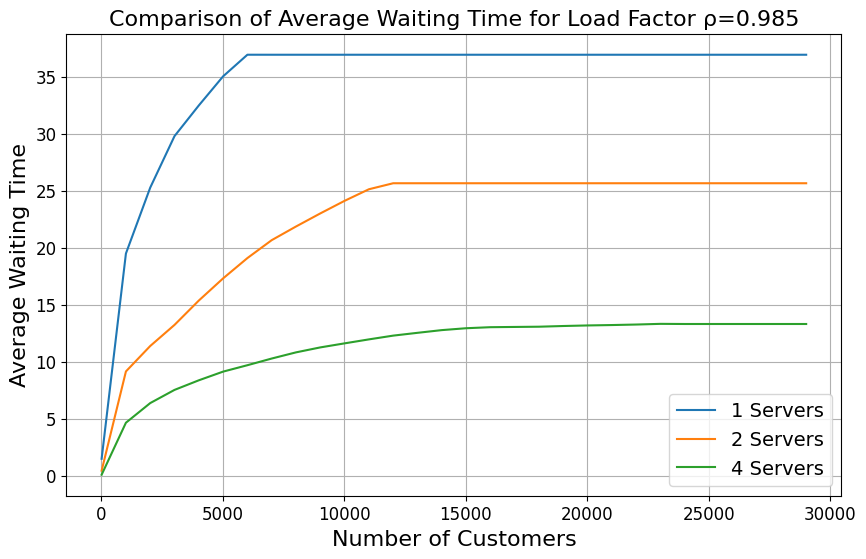

In [131]:
def plot_comparison_by_servers_for_load_factor(
    results_dfs: dict, server_counts: list, load_factor: float = load_factors[-1]
) -> None:
    """Plot the comparison of average waiting time for a specific load factor across different server counts.

    Args:
        results_dfs: A dictionary where keys are server counts and values are pandas DataFrames
                     containing simulation results.
        server_counts: A list of server counts to include in the plot (e.g., [1, 2, 4]).
        load_factor: The specific load factor (ρ) to compare (e.g., 0.975).

    Returns:
        None. Displays a line plot.
    """
    plt.figure(figsize=(10, 6))

    for servers in server_counts:
        results_df = results_dfs[servers]

        # Filter the DataFrame for the specific load factor
        subset = results_df[results_df["Load Factor"] == load_factor]

        # Group by 'Customers' and calculate the mean wait time
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()

        # Plot the average waiting times
        plt.plot(avg_waits.index, avg_waits.values, label=f"{servers} Servers")

    plt.title(f"Comparison of Average Waiting Time for Load Factor ρ={load_factor}", fontsize=16)
    plt.xlabel("Number of Customers", fontsize=16)
    plt.ylabel("Average Waiting Time", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=12)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()


results_dfs = {1: results_df_mm1, 2: results_df_mm2, 4: results_df_mm4}

# Call the plotting function for the highest load factor
plot_comparison_by_servers_for_load_factor(
    results_dfs, server_counts=[1, 2, 4]
)

### Exercise 2: Comparing M/M/n average waiting times with equal arrival rates (scaled by n) with statistical analysis

In [132]:
def run_single_simulation(
    servers_count: int,
    arrival_rate: float,
    service_rate: float,
    simulation_time: int,
    runs: int,
    client_process: Callable = markovian_client_process,
    short_job_priority: bool = False,
) -> float:
    """Run a single simulation with a set configuration multiple times to compute the average waiting time.

    This function is executed for M/M/n FIFO by default.

    Args:
        servers_count: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        simulation_time: Total simulation time.
        runs: Number of iterations to run for statistical significance.
        client_process: Function that calculates the process of a client through the system.
            Defaults to process with markovian service time.
        short_job_priority: Scheduling type for queue network. SJP if True, FIFO else.

    Returns:
        Tuple containing:
        - Mean waiting time across all runs.
        - Standard deviation of waiting times across all runs.
    """
    # Record all waiting times of the runs
    wait_times = []
    for _ in tqdm(range(runs), desc=f"Running for n={servers_count}, λ={arrival_rate}"):
        recorded_waits = simulate_queue_network(
            servers_count,
            arrival_rate,
            service_rate,
            simulation_time,
            client_process=client_process,
            short_job_priority=short_job_priority,
        )
        wait_times.append(np.mean(recorded_waits))

    return np.mean(wait_times), np.std(wait_times)


def statistical_comparison_servers(load_factor: float, results: dict, runs: int, p_val: float = 0.95) -> None:
    """Compare the results of multiple simulations with different amount of servers.
    
    Expects results to include a run with 1 server.

    Args:
        load_factor: The load factor (ρ) used in the simulation.
        results: Dictionary containing mean and std of waiting time of each configuration of servers.
        runs: The amount of runs used for the simulation.
        p_val: p-value for which the confidence interval will be calculated.

    Returns:
        None. Prints out some statistics of these simulations.
    """
    # Print results
    print(f"\nSimulation Results (ρ={load_factor}):")
    for servers, statistics in results.items():
        # Calculate the confidence interval for a given p-value
        margin = (norm.ppf((p_val + 1) / 2) * statistics['Std Dev']) / np.sqrt(runs)

        print(
            f"n={servers}: "
            f"Mean Wait Time = {statistics['Mean Wait Time']:.4f}, "
            f"Standard Deviation = {statistics['Std Dev']:.4f}, "
            f"Confidence interval (p={p_val}) = ({(statistics['Mean Wait Time']-margin):.4f}, {(statistics['Mean Wait Time']+margin):.4f})"
        )

    # Compare to n=1
    print("\nInsights:")
    for servers in server_configs[1:]:
        reduction = (
            (results[1]["Mean Wait Time"] - results[servers]["Mean Wait Time"])
            / results[1]["Mean Wait Time"]
            * 100
        )
        print(
            f"Adding more servers (n={servers}): "
            f"Wait time reduced by {reduction:.2f}% compared to n=1."
        )

# Override config parameters
load_factor = load_factors[-1]
simulation_time = 6000
runs = 200
server_configs = [1, 2, 4]

# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(
        servers, arrival_rate, service_rate, simulation_time, runs
    )
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

statistical_comparison_servers(load_factor, results, runs)

Running for n=4, λ=3.94: 100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


Simulation Results (ρ=0.985):
n=1: Mean Wait Time = 35.9240, Standard Deviation = 19.1678, Confidence interval (p=0.95) = (33.2675, 38.5805)
n=2: Mean Wait Time = 24.5309, Standard Deviation = 15.7678, Confidence interval (p=0.95) = (22.3456, 26.7162)
n=4: Mean Wait Time = 13.8061, Standard Deviation = 7.9062, Confidence interval (p=0.95) = (12.7104, 14.9019)

Insights:
Adding more servers (n=2): Wait time reduced by 31.71% compared to n=1.
Adding more servers (n=4): Wait time reduced by 61.57% compared to n=1.


### Exercise 3: Testing the same, but with short job priority job scheduling (instead of FIFO)

In [133]:
# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(
        servers, arrival_rate, service_rate, simulation_time, runs, short_job_priority=True
    )
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

statistical_comparison_servers(load_factor, results, runs)

Running for n=4, λ=3.94: 100%|██████████| 200/200 [02:05<00:00,  1.59it/s]


Simulation Results (ρ=0.985):
n=1: Mean Wait Time = 37.7256, Standard Deviation = 21.1273, Confidence interval (p=0.95) = (34.7975, 40.6536)
n=2: Mean Wait Time = 23.7853, Standard Deviation = 13.1105, Confidence interval (p=0.95) = (21.9683, 25.6023)
n=4: Mean Wait Time = 12.7162, Standard Deviation = 8.4042, Confidence interval (p=0.95) = (11.5514, 13.8809)

Insights:
Adding more servers (n=2): Wait time reduced by 36.95% compared to n=1.
Adding more servers (n=4): Wait time reduced by 66.29% compared to n=1.


### Exercise 4: Testing different service rate distributions (deterministic and long-tail)

Running simulations for different load factors: 100%|██████████| 4/4 [03:05<00:00, 46.37s/it]


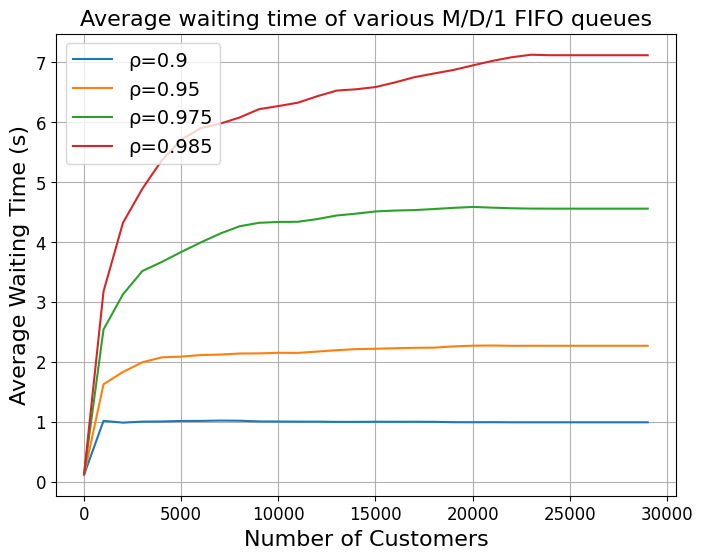

In [134]:
def service_time_generator_deterministic(service_rate: float) -> float:
    """Generate deterministic service times.

    Specifically, returns one divided by the parameter 'service rate' = μ.

    Args:
        service_rate: The service rate or capacity of each server (μ).

    Returns:
        Deterministic number calculated with the service rate.
    """
    return 1 / service_rate


def deterministic_client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system, including waiting and service times.

    Specifically, simulates it with a service time that is deterministic (=constant).

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        # Wait for resource availability
        yield request

        # Record the wait time
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)

        # Simulate service time
        yield env.timeout(
            service_time_generator_deterministic(service_rate)
        )


# Run simulations
results_df_md1 = run_simulations(
    load_factors,
    runs_per_config,
    servers_count,
    service_rate,
    simulation_time,
    client_process=deterministic_client_process,
)

# Save the results to a CSV
results_df_md1.to_csv("sim_md1.csv", index=False)

# Plot the results
plot_simulations(
    results_df_md1, load_factors, plot_title="Average waiting time of various M/D/1 FIFO queues"
)

In [135]:
# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(
        servers, arrival_rate, service_rate, simulation_time, runs, client_process=deterministic_client_process
    )
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

statistical_comparison_servers(load_factor, results, runs)

Running for n=4, λ=3.94: 100%|██████████| 200/200 [01:31<00:00,  2.20it/s]


Simulation Results (ρ=0.985):
n=1: Mean Wait Time = 21.9999, Standard Deviation = 12.7099, Confidence interval (p=0.95) = (20.2384, 23.7614)
n=2: Mean Wait Time = 13.2140, Standard Deviation = 6.8294, Confidence interval (p=0.95) = (12.2675, 14.1605)
n=4: Mean Wait Time = 7.7881, Standard Deviation = 4.3695, Confidence interval (p=0.95) = (7.1826, 8.3937)

Insights:
Adding more servers (n=2): Wait time reduced by 39.94% compared to n=1.
Adding more servers (n=4): Wait time reduced by 64.60% compared to n=1.


The service rate for this queue is 0.5. Note that the load factor is still
a fixed number, so the arrival rate will be adjusted accordingly (higher than previous simulations).


Running simulations for different load factors: 100%|██████████| 4/4 [00:27<00:00,  6.90s/it]


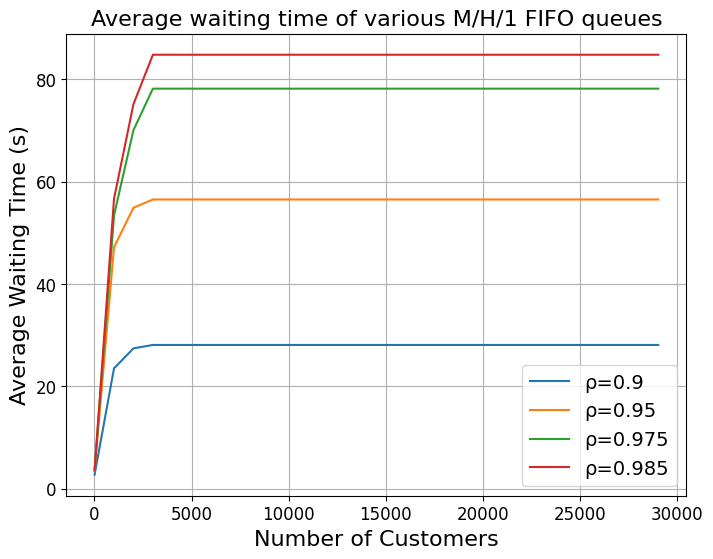

In [136]:
def service_time_generator_hyperexponential(p1: float, mean1: float, mean2: float) -> float:
    """Generate service times from a hyperexponential distribution.

    Specifically, draws a random variable from the exponential distribution with
        mean `mean1` with probability `p1`. Otherwise, draws from the exponential
        distribution with mean `mean2`.

    Args:
        p1: The probability of selecting the first distribution.
        mean1: Mean of the first exponential distribution (1/λ1).
        mean2: Mean of the second exponential distribution (1/λ2).

    Returns:
        A service time drawn from the hyperexponential distribution.
    """
    if random.random() < p1:
        return random.expovariate(1 / mean1)
    else:
        return random.expovariate(1 / mean2)


def hyperexponential_client_process_factory(p1: float, mean1: float, mean2: float) -> Callable:
    """Factory function to create a client_process function for hyperexponential service times.

    Args:
        p1: The probability of selecting the first distribution.
        mean1: Mean of the first exponential distribution (1/λ1).
        mean2: Mean of the second exponential distribution (1/λ2).

    Returns:
        Function that can be used as a client process of a hyperexponential distribution.
    """

    def hyperexponential_client_process(
        env: simpy.Environment,
        resources: simpy.Resource,
        service_rate: float,  # This parameter is required but not used
        wait_records: List[float],
    ) -> Generator[simpy.events.Event, None, None]:
        arrival_time = env.now
        with resources.request() as request:
            # Wait for resource availability
            yield request

            # Record the wait time
            wait_time = env.now - arrival_time
            wait_records.append(wait_time)

            # Simulate service time
            service_time = service_time_generator_hyperexponential(p1, mean1, mean2)
            yield env.timeout(service_time)

    return hyperexponential_client_process


# Parameters
servers_count = 1
p1 = 0.75
mean1 = 1.0
mean2 = 5.0

# Service rate for hyperexponetial distribution can be calculated as the inverse of the average service time
service_rate = 1 / (p1 * mean1 + (1 - p1) * mean2)
print(
    f"The service rate for this queue is {service_rate}. Note that the load factor is still\n"
    f"a fixed number, so the arrival rate will be adjusted accordingly (higher than previous simulations)."
)

# Run simulations
results_df_mh1 = run_simulations(
    load_factors,
    runs_per_config,
    servers_count,
    service_rate,
    simulation_time,
    client_process=hyperexponential_client_process_factory(p1, mean1, mean2),
)

# Save the results to a CSV
results_df_mh1.to_csv("sim_mh1.csv", index=False)

# Plot the results
plot_simulations(
    results_df_mh1, load_factors, plot_title="Average waiting time of various M/H/1 FIFO queues"
)

In [137]:
# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(
        servers,
        arrival_rate,
        service_rate,
        simulation_time,
        runs,
        client_process=hyperexponential_client_process_factory(p1, mean1, mean2),
    )
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

statistical_comparison_servers(load_factor, results, runs)

Running for n=4, λ=1.97: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


Simulation Results (ρ=0.985):
n=1: Mean Wait Time = 81.8680, Standard Deviation = 51.4676, Confidence interval (p=0.95) = (74.7351, 89.0009)
n=2: Mean Wait Time = 53.7065, Standard Deviation = 31.5359, Confidence interval (p=0.95) = (49.3359, 58.0771)
n=4: Mean Wait Time = 33.7886, Standard Deviation = 22.7386, Confidence interval (p=0.95) = (30.6373, 36.9400)

Insights:
Adding more servers (n=2): Wait time reduced by 34.40% compared to n=1.
Adding more servers (n=4): Wait time reduced by 58.73% compared to n=1.


## Extras: some other things we played around with, but did not end up making it in the report. Note that we did not write this code too cleanly, as this is not actually part of our delivered material. 

### Testing average queue length for M/M/1 FIFO. Note that the analytical solution tells us: $L_q = \rho^2/(1-\rho) \approx 18$


Total customers processed across 200 runs: 3797272


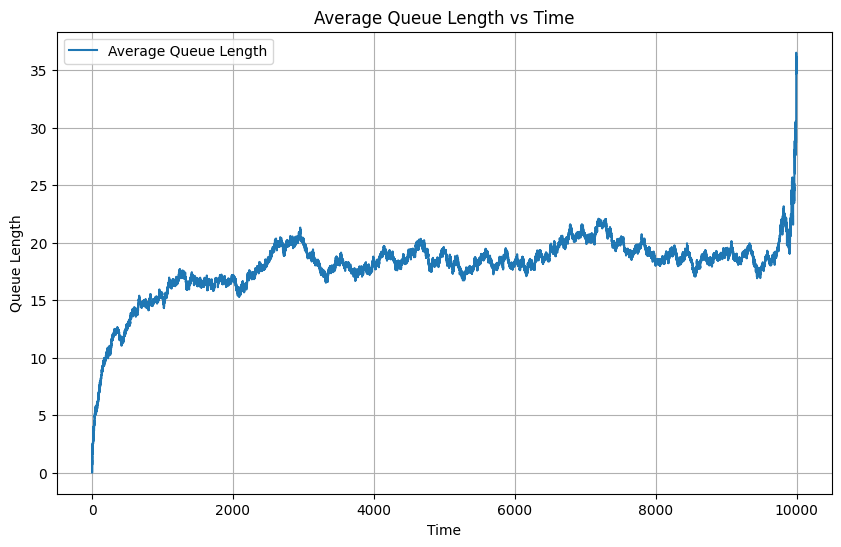

In [138]:
def interval_generator_markov_2(arrival_rate: float) -> float:
    """Generate a random number from an exponential distribution for interarrival times."""
    return random.expovariate(arrival_rate)

def service_time_generator_markov_2(service_rate: float) -> float:
    """Generate a random number from an exponential distribution for service times."""
    return random.expovariate(service_rate)

def client_process_2(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    queue_lengths: List[Tuple[float, int]],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system."""
    arrival_time = env.now
    with resources.request() as request:
        queue_lengths.append((env.now, len(resources.queue) + 1))  # Record queue length
        yield request  # Wait for resource availability
        queue_lengths.append((env.now, len(resources.queue)))  # Update queue length
        yield env.timeout(service_time_generator_markov_2(service_rate))  # Simulate service time

def request_spawner_2(
    env: simpy.Environment,
    resources: simpy.Resource,
    arrival_rate: float,
    service_rate: float,
    queue_lengths: List[Tuple[float, int]],
    client_process: Callable[[simpy.Environment, simpy.Resource, float, List[Tuple[float, int]]], Generator[simpy.events.Event, None, None]]
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes based on interarrival times."""
    while True:
        yield env.timeout(interval_generator_markov_2(arrival_rate))
        env.process(client_process(env, resources, service_rate, queue_lengths))

def simulate_queue_network_2(
    num_servers: int, arrival_rate: float, service_rate: float, sim_time: float
) -> Tuple[List[Tuple[float, int]], int]:
    """Simulates a queueing network and tracks queue lengths and total customers."""
    load_factor = arrival_rate / (num_servers * service_rate)
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    env = simpy.Environment()
    resources = simpy.Resource(env, capacity=num_servers)
    queue_lengths: List[Tuple[float, int]] = []  # Queue lengths over time
    customer_count = 0  # Track the total number of customers

    def wrapped_client_process(*args, **kwargs):
        nonlocal customer_count
        customer_count += 1
        return client_process_2(*args, **kwargs)

    env.process(
        request_spawner_2(
            env, resources, arrival_rate, service_rate, queue_lengths, wrapped_client_process
        )
    )
    env.run(until=sim_time)
    return queue_lengths, customer_count

def run_simulations_with_averaging_2(
    num_servers: int,
    arrival_rate: float,
    service_rate: float,
    sim_time: float,
    runs_per_config: int,
) -> Tuple[List[Tuple[float, float]], int]:
    """Runs multiple simulations and averages queue lengths over time."""
    all_runs = []

    for _ in range(runs_per_config):
        queue_lengths, customer_count = simulate_queue_network_2(num_servers, arrival_rate, service_rate, sim_time)
        all_runs.append(queue_lengths)

    # Aggregate queue lengths by averaging over runs
    times = [length[0] for length in all_runs[0]]  # Use the first run's times
    avg_lengths = []
    for i in range(len(times)):
        lengths_at_time = [run[i][1] for run in all_runs if i < len(run)]  # Gather lengths at the same time
        avg_lengths.append((times[i], sum(lengths_at_time) / len(lengths_at_time)))

    # Total customers processed across all runs
    total_customers = sum(len(run) for run in all_runs)
    return avg_lengths, total_customers

def plot_queue_length_2(queue_lengths: List[Tuple[float, float]]) -> None:
    """Plots the average queue length vs. time."""
    times, lengths = zip(*queue_lengths)
    plt.figure(figsize=(10, 6))
    plt.plot(times, lengths, label="Average Queue Length")
    plt.title("Average Queue Length vs Time")
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation Parameters
load_factor = 0.95
servers_count = 1
service_rate = 1.0
arrival_rate = load_factor * servers_count * service_rate
simulation_time = 10000
runs_per_config = 200

# Run simulations with averaging
avg_queue_lengths, total_customers = run_simulations_with_averaging_2(
    servers_count, arrival_rate, service_rate, simulation_time, runs_per_config
)

# Print total customers processed
print(f"Total customers processed across {runs_per_config} runs: {total_customers}")

# Plot the average queue length vs time
plot_queue_length_2(avg_queue_lengths)